### Insights follow-up: Reconcile fiber campuses

#### Why:
last week, the number of unscalable campuses was 760, and now its 778

#### What:
evan is interested in knowing the high-level reasons for this change.

#### How:
we have been taking snapshots of the database daily. please choose a database from last week where the number of unscalable campuses were 760, and compare to the number of unscalable campuses in the frozen database

- which districts changed?
- were all the districts in one state?
- were most of the districts PotNoDat, so the changes are due to extrapolation?

In [59]:
import numpy as np
import os
import psycopg2
import pandas as pd
from matplotlib import pyplot as plt

In [60]:
# dar prod
HOST_DAR = os.environ.get("HOST_DAR")
USER_DAR = os.environ.get("USER_DAR")
PASSWORD_DAR = os.environ.get("PASSWORD_DAR")
DB_DAR = os.environ.get("DB_DAR")
PORT_DAR = os.environ.get("PORT_DAR")
GITHUB = os.environ.get("GITHUB")

In [61]:
#open connection to Dar prod
myConnection = psycopg2.connect( host=HOST_DAR, 
                                user=USER_DAR, 
                                password=PASSWORD_DAR, 
                                database=DB_DAR, 
                                port=PORT_DAR)

### QA Task 1

In [62]:
sql_query = """
select 
  d.funding_year, 
  d.district_id, 
  d.name, 
  d.state_code, 
  d.num_campuses,
  df.known_unscalable_campuses,
  df.assumed_unscalable_campuses,
  (df.known_unscalable_campuses + df.assumed_unscalable_campuses) as total_unscalable_campuses 
from 
  ps.districts_fiber df 
  join ps.districts d on d.district_id = df.district_id 
  and d.funding_year = df.funding_year 
where 
  d.funding_year = 2019 
  and d.district_type = 'Traditional' 
"""

#pull 
cur = myConnection.cursor()
cur.execute(sql_query)
names = [x[0] for x in cur.description]
rows = cur.fetchall()
df_dar = pd.DataFrame(rows, columns=names)

In [63]:
# using jamie_geotelsp_081419
HOST_SPINER ='beautifly-psql1.cyttrh279zkr.us-east-1.rds.amazonaws.com'
USER_SPINER = os.environ.get("USER_SPINER")
PASSWORD_SPINER = os.environ.get("PASSWORD_SPINER")
DB_SPINER = "jamie_geotelsp_081419"
PORT_SPINER = os.environ.get("PORT_SPINER")
GITHUB = os.environ.get("GITHUB")

#open connection to old db
myConnection = psycopg2.connect( host=HOST_SPINER, 
                                user=USER_SPINER, 
                                password=PASSWORD_SPINER, 
                                database=DB_SPINER, 
                                port=PORT_SPINER)

#pull 
cur = myConnection.cursor()
cur.execute(sql_query)
names = [x[0] for x in cur.description]
rows = cur.fetchall()
df_old = pd.DataFrame(rows, columns=names)

### Merge dataframes for comparison

In [64]:
df_merge = pd.merge(df_old, df_dar, indicator=True, how='outer', on=['funding_year', 'district_id'], suffixes=('_prev', '_prod'))
df_merge.sort_values(['funding_year', 'district_id'], inplace=True)

In [65]:
# convert decimal to numeric
numeric_cols = ['known_unscalable_campuses_prev', 'assumed_unscalable_campuses_prev','total_unscalable_campuses_prev', 
       'known_unscalable_campuses_prod', 'assumed_unscalable_campuses_prod','total_unscalable_campuses_prod']
df_merge[numeric_cols] = df_merge[numeric_cols].astype(float)

### Add boolean column to see difference between total unscalable campuses

In [66]:
# boolean diff
df_merge['same_unscalable_campuses'] = np.isclose(df_merge['total_unscalable_campuses_prev'], df_merge['total_unscalable_campuses_prod'])
df_merge['same_known_unscalable_campuses'] = np.isclose(df_merge['known_unscalable_campuses_prev'], df_merge['known_unscalable_campuses_prod'])
df_merge['same_assumed_unscalable_campuses'] = np.isclose(df_merge['assumed_unscalable_campuses_prev'], df_merge['assumed_unscalable_campuses_prod'])
df_merge['same_num_campuses'] = np.isclose(df_merge['num_campuses_prev'], df_merge['num_campuses_prod'])


# what are the actual diffs?
df_merge['val_diff_unscalable_campues'] = df_merge['total_unscalable_campuses_prev'] - df_merge['total_unscalable_campuses_prod']
df_merge['val_diff_known_unscalable_campuses'] = df_merge['known_unscalable_campuses_prev'] - df_merge['known_unscalable_campuses_prod']
df_merge['val_diff_assumed_unscalable_campuses'] = df_merge['assumed_unscalable_campuses_prev'] - df_merge['assumed_unscalable_campuses_prod']
df_merge['val_diff_num_campuses'] = df_merge['num_campuses_prev'] - df_merge['num_campuses_prod']



### QA Task 2

In [67]:
print(f"Number of unscalable campuses (previous): {df_merge.total_unscalable_campuses_prev.sum()}")
print(f"Number of unscalable campuses (dar-prod): {df_merge.total_unscalable_campuses_prod.sum()}")

Number of unscalable campuses (previous): 761.3760165282147
Number of unscalable campuses (dar-prod): 780.1604726218457


### QA Task 3

### Fiber Goal

In [68]:
pct_fiber_prev = 1 - (df_merge.total_unscalable_campuses_prev.sum()/df_old.num_campuses.sum())
pct_fiber_prod = 1 - (df_merge.total_unscalable_campuses_prod.sum()/df_dar.num_campuses.sum())

In [69]:
print(f"Fiber goal (Previous): {round(pct_fiber_prev*100, 2)}%")
print(f"Fiber goal (Current): {round(pct_fiber_prod*100, 2)}%")

Fiber goal (Previous): 98.96%
Fiber goal (Current): 98.93%


### how many districts in _prev only, _prod only, both?

In [18]:
# left: _previous
# right: _prod
df_merge._merge.value_counts()

both          12910
left_only         2
right_only        0
Name: _merge, dtype: int64

In [19]:
print(f"Number of districts found in both previous db and dar-prod: {df_merge._merge.value_counts()['both']}")
print(f"Number of districts found in previous db only: {df_merge._merge.value_counts()['left_only']}")
print(f"Number of districts found in dar-prod only: {df_merge._merge.value_counts()['right_only']}")

Number of districts found in both previous db and dar-prod: 12910
Number of districts found in previous db only: 2
Number of districts found in dar-prod only: 0


### Plot: Bar - district counts, campus counts, known unscalable, assumed unscalable


In [21]:
# total number of districts
num_d_dar = df_dar.district_id.nunique()
num_d_prev = df_old.district_id.nunique()

# create plot dataframes
df_plot = pd.DataFrame({'district_counts': [num_d_prev, num_d_dar], 
                        'campus_counts': [df_old.num_campuses.sum(), df_dar.num_campuses.sum()],
                        'known_unscalable_counts': [df_old.known_unscalable_campuses.sum(), df_dar.known_unscalable_campuses.sum()],
                        'assumed_unscalable_counts': [df_old.assumed_unscalable_campuses.sum(), df_dar.assumed_unscalable_campuses.sum()],
                        'time_category':['Previous - 081419', "Current - DAR-PROD"]})
df_plot.set_index('time_category', inplace=True)

# add diff column
df_plot['diff_districts'] = df_plot.district_counts.diff()
df_plot['diff_campuses'] = df_plot.campus_counts.diff()
df_plot['diff_known'] = df_plot.known_unscalable_counts.diff()
df_plot['diff_assumed'] = df_plot.assumed_unscalable_counts.diff()

# fill in nan with top val
df_plot.fillna(0, inplace=True)

### Plot

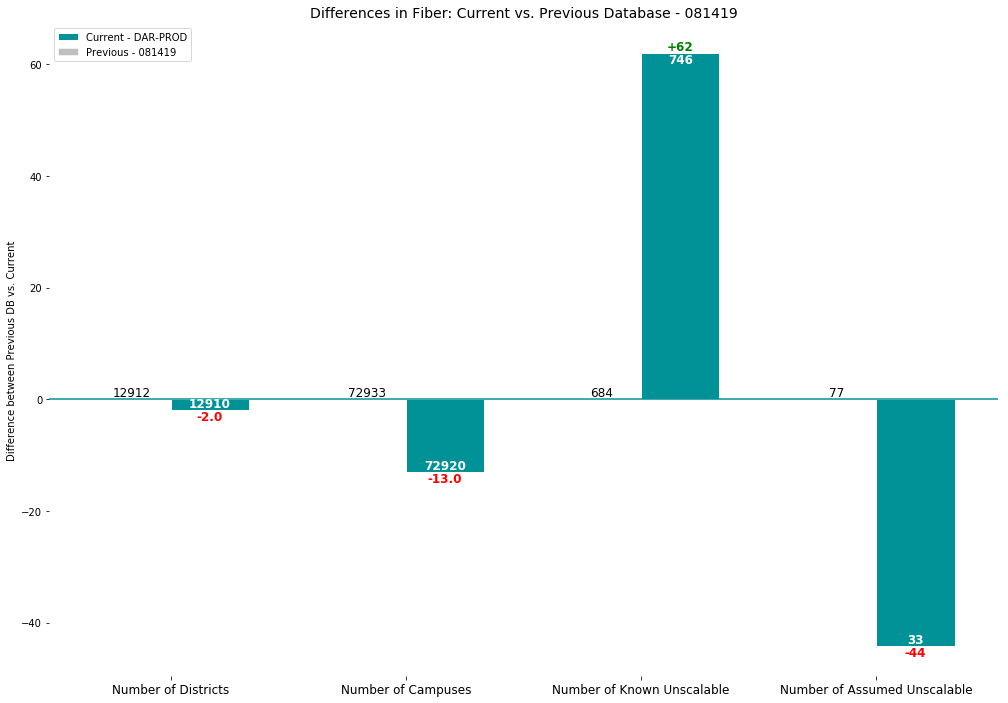

In [57]:
# indices where bar plot will go
xmarks = np.arange(0, 4)

fig = plt.figure(figsize=(17, 12))
ax = fig.add_subplot(111)
width = np.min(np.diff(xmarks))/3

# Number of Districts
ax.bar(xmarks+width/2., 
       df_plot.loc['Current - DAR-PROD', ['diff_districts', 'diff_campuses', 'diff_known', 'diff_assumed']].values, 
       width, color='#009296', edgecolor='white', label='Current - DAR-PROD')
ax.bar(xmarks-width/2., 0.0, 
       width, color='grey', edgecolor='white', label='Previous - 081419', alpha=.5)


#ax.set_title('Differences', color='#f26c23', fontweight='bold')
ax.set_xticks(xmarks)
ax.set_xticklabels(['Number of Districts', 
                    'Number of Campuses', 
                    'Number of Known Unscalable', 
                    'Number of Assumed Unscalable'], fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_yaxis().set_visible(True)
ax.set_ylabel("Difference between Previous DB vs. Current")
ax.axhline(y=0, color='#009296') # horizontal line

# Number of Districts
plt.text(xmarks[0]+width/2, 
         df_plot.loc['Current - DAR-PROD', 'diff_districts'], 
         df_plot.loc['Current - DAR-PROD', 'district_counts'], 
         ha='center', va='bottom', color='white', fontsize=12, fontweight='bold')
plt.text(xmarks[0]-width/2, 
         df_plot.loc['Previous - 081419', 'diff_districts'], 
         df_plot.loc['Previous - 081419', 'district_counts'], 
         ha='center', va='bottom', fontsize=12);
plt.text(xmarks[0]+width/2, 
         df_plot.loc['Current - DAR-PROD', 'diff_districts'], 
         df_plot.loc['Current - DAR-PROD', 'diff_districts'], 
         ha='center', va='top', color='red', fontsize=12, fontweight='bold')

# Number of Campuses
plt.text(xmarks[1]+width/2, 
         df_plot.loc['Current - DAR-PROD', 'diff_campuses'], 
         df_plot.loc['Current - DAR-PROD', 'campus_counts'], 
         ha='center', va='bottom', color='white', fontsize=12, fontweight='bold')
plt.text(xmarks[1]-width/2, 
         df_plot.loc['Previous - 081419', 'diff_campuses'], 
         df_plot.loc['Previous - 081419', 'campus_counts'], 
         ha='center', va='bottom', fontsize=12);
# diff label
plt.text(xmarks[1]+width/2, 
         df_plot.loc['Current - DAR-PROD', 'diff_campuses'], 
         df_plot.loc['Current - DAR-PROD', 'diff_campuses'], 
         ha='center', va='top', color='red', fontsize=12, fontweight='bold')

# Number of Known Unscalable
plt.text(xmarks[2]+width/2, 
         df_plot.loc['Current - DAR-PROD', 'diff_known'], 
         df_plot.loc['Current - DAR-PROD', 'known_unscalable_counts'], 
         ha='center', va='top', color='white', fontsize=12, fontweight='bold')
plt.text(xmarks[2]-width/2, 
         df_plot.loc['Previous - 081419', 'diff_known'], 
         df_plot.loc['Previous - 081419', 'known_unscalable_counts'], 
         ha='center', va='bottom', fontsize=12);
# diff label
plt.text(xmarks[2]+width/2, 
         df_plot.loc['Current - DAR-PROD', 'diff_known'], 
         '+' + str(df_plot.loc['Current - DAR-PROD', 'diff_known']), 
         ha='center', va='bottom', color='green', fontsize=12, fontweight='bold')

# Number of Assumed Unscalable
plt.text(xmarks[3]+width/2, 
         df_plot.loc['Current - DAR-PROD', 'diff_assumed'], 
         round(df_plot.loc['Current - DAR-PROD', 'assumed_unscalable_counts']), 
         ha='center', va='bottom', color='white', fontsize=12, fontweight='bold')
plt.text(xmarks[3]-width/2, 
         df_plot.loc['Previous - 081419', 'diff_assumed'], 
         round(df_plot.loc['Previous - 081419', 'assumed_unscalable_counts']), 
         ha='center', va='bottom', fontsize=12);
plt.text(xmarks[3]+width/2, 
         df_plot.loc['Current - DAR-PROD', 'diff_assumed'], 
         round(df_plot.loc['Current - DAR-PROD', 'diff_assumed']), 
         ha='center', va='top', color='red', fontsize=12, fontweight='bold')

plt.title("Differences in Fiber: Current vs. Previous Database - 081419",  fontsize=14)
plt.legend(loc='upper left');

# save figure
plt.savefig("reconcile_fiber.png", bbox_inches = 'tight')

### What are the two different districts?

In [55]:
df_d_diffs = df_merge[df_merge._merge == 'left_only']
df_d_diffs

,funding_year,district_id,name_prev,state_code_prev,num_campuses_prev,known_unscalable_campuses_prev,assumed_unscalable_campuses_prev,total_unscalable_campuses_prev,name_prod,state_code_prod,...,total_unscalable_campuses_prod,_merge,same_unscalable_campuses,same_known_unscalable_campuses,same_assumed_unscalable_campuses,same_num_campuses,val_diff_unscalable_campues,val_diff_known_unscalable_campuses,val_diff_assumed_unscalable_campuses,val_diff_num_campuses
4281,2019,911007,Amherst,MA,3,0.0,0.0,0.0,NaN,NaN,...,NaN,left_only,False,False,False,False,NaN,NaN,NaN,NaN
6366,2019,928893,Dupuyer School District 2,MT,1,0.0,1.0,1.0,NaN,NaN,...,NaN,left_only,False,False,False,False,NaN,NaN,NaN,NaN


In [56]:
df_d_diffs.to_csv("fiber_district_diffs_082919.csv", index=False)

### Notes:
- 911007 Amherst MA - In Universe in 2018, no longer In Universe 2019; Merged into different district
- 928893 Dupuyer School District 2 MT - In Universe in 2018, no longer In Universe 2019; Got info it was Closed

### Decrease in Number of Campuses?

In [53]:
sub_cols = ['funding_year', 'district_id',
            'name_prev', 'state_code_prev', 
            'num_campuses_prev', 'num_campuses_prod']
df_campus = df_merge[df_merge.same_num_campuses == False][sub_cols]
df_campus

,funding_year,district_id,name_prev,state_code_prev,num_campuses_prev,num_campuses_prod
41,2019,881521,Mountain Valley Unified School District,CA,3,2.0
2793,2019,901027,Chicago Public Schools,IL,505,503.0
2999,2019,901276,Jasper County School District 1,IL,3,2.0
4281,2019,911007,Amherst,MA,3,NaN
4282,2019,911008,Amherst-Pelham K-12 Superintendency Union,MA,2,4.0
6366,2019,928893,Dupuyer School District 2,MT,1,NaN
10067,2019,953827,Halifax Area School District,PA,3,2.0
10327,2019,954148,Tussey Mountain School District,PA,4,2.0
10419,2019,959631,Tiverton School District,RI,4,3.0
10449,2019,962249,Darlington County School District,SC,21,19.0


In [54]:
df_campus.to_csv("fiber_campus_diffs_082919.csv", index=False)

### Notes:
- From the two districts no longer in universe, decrease of 4 campuses and change in campusing assignment (example Amherst) (3 - Amherst, 1 - Dupuyer School District 2)
- 881521 Mountain Valley Unified School District CA	- Closed Schools (2)

- 901027 Chicago Public Schools	IL - Marshall Middle - Closed School

### Increase in Known Scalable

#### Reasons


state_code_prev
- CA    13 - Check with Adam. Fixing allocations. Confirmation from CA team? Mistakes and corrected them?
- MT    10 - Clarification from PotNoDat group (no data's and are now fiber targets)
- OR     8 - Willamina School District 30 (New line item make it eligible for Wireless exclusion, but this will revert back to target after cleaning); Warm Springs K 8 Academy - Fiber logic change
- PA     3

In [50]:
sub_cols = ['funding_year', 'district_id',
            'name_prev', 'state_code_prev', 
            'known_unscalable_campuses_prev','known_unscalable_campuses_prod']
df_known = df_merge[(df_merge.same_known_unscalable_campuses == False) & 
         ~(df_merge.known_unscalable_campuses_prod.isnull())
        ][sub_cols]

In [51]:
df_known.to_csv("fiber_known_diffs_082919.csv", index=False)

### Decrease in Number of Assumed Unscalable

- NE - PotNoDat working group, clarified Potentials to Non-targets
- PA - Ferndale - Assumed now is Known
- CT - Oxford School District- Confirmed from state outreach

In [48]:
# ~(df_merge.known_unscalable_campuses_prod.isnull()
sub_cols = ['funding_year', 'district_id',
            'name_prev', 'state_code_prev', 
            'assumed_unscalable_campuses_prev','assumed_unscalable_campuses_prod']
df_assumed = df_merge[(df_merge.same_assumed_unscalable_campuses == False)][sub_cols]
df_assumed

,funding_year,district_id,name_prev,state_code_prev,assumed_unscalable_campuses_prev,assumed_unscalable_campuses_prod
16,2019,881452,Cuyama Joint Unified School District,CA,0.160000,0.000000
41,2019,881521,Mountain Valley Unified School District,CA,0.080000,0.000000
286,2019,882079,Clinton Public School District 1,AR,0.008436,0.240000
389,2019,882259,Centerpoint School District,AR,0.240000,0.000000
394,2019,882269,St Clair County School District,AL,0.720000,0.000000
591,2019,882632,Galena City School District,AK,0.160000,0.000000
649,2019,882710,Russellville School District 14,AR,0.002812,0.000000
726,2019,882830,White Hall School District,AR,0.011248,0.000000
765,2019,882932,Borrego Springs Unified School District,CA,0.160000,0.000000
999,2019,883253,Edison School District,CA,0.160000,0.000000


In [49]:
df_assumed.to_csv("fiber_assumed_diffs_082919.csv", index=False)

In [1]:
# convert jupyter notebook to .py
!jupyter nbconvert --to script reconcile_fiber.ipynb

[NbConvertApp] Converting notebook reconcile_fiber.ipynb to script
[NbConvertApp] Writing 13578 bytes to reconcile_fiber.py
